In [1]:
#Library Imports
import pandas
import sklearn
import numpy
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import chi2
import json
import ast
import os
import glob
import operator

In [2]:
dataFile='sampleData'
silhouetteThreshold=0.65
statsPath = "Statistics/Hierarchical/"+str(dataFile)+"/"
visualisationDirectory="Visualisation/"
modelNameFilePath='Visualisation/models.txt'
user=[]
max_abs_scaler = preprocessing.MaxAbsScaler()
#transformedValues = max_abs_scaler.fit_transform(vector)
vector = pandas.read_csv('Data/'+dataFile+'.csv')
print(vector.head(n=len(vector)).describe())
attributes = list(vector.columns[1:])
transformedValues=vector.iloc[:,1:].values.tolist()
user=vector.iloc[:,0].values.tolist()

# Stats Path to be created
if not os.path.exists(statsPath):
    os.makedirs(statsPath)
else:
    files = glob.glob(statsPath+'/*')
    for f in files:
        os.remove(f)

               IDS     Feature1     Feature2     Feature3     Feature4  \
count  6394.000000  6394.000000  6394.000000  6394.000000  6394.000000   
mean   3196.500000     0.766813     0.011573     0.000313     0.006725   
std    1845.933143     8.763783     0.183448     0.017685     0.121716   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%    1598.250000     0.000000     0.000000     0.000000     0.000000   
50%    3196.500000     0.000000     0.000000     0.000000     0.000000   
75%    4794.750000     0.000000     0.000000     0.000000     0.000000   
max    6393.000000   407.000000    10.000000     1.000000     5.000000   

          Feature5     Feature6     Feature7     Feature8     Feature9  \
count  6394.000000  6394.000000  6394.000000  6394.000000  6394.000000   
mean      0.049891     0.015796     0.012512     0.017047     0.015796   
std       0.600730     0.200658     0.200500     0.375026     0.320674   
min       0.000000     0.000000     0

Silhouette Score :0.9627630439466378
Cluster Count :2


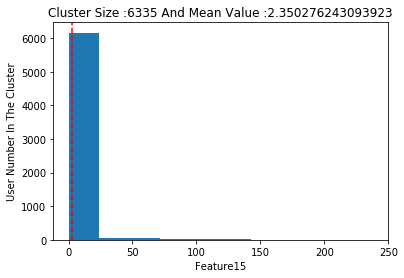

Level :1
Feature15
Cluster Size :6335
______________________________________
Silhouette Score :0.9302755285032738
Cluster Count :2


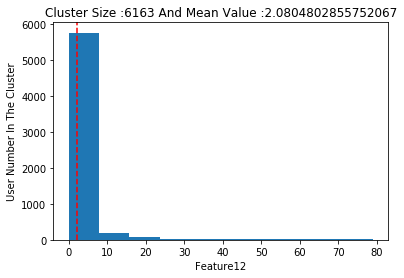

Level :2
Feature12
Cluster Size :6163
______________________________________
Silhouette Score :0.968641156074839
Cluster Count :2


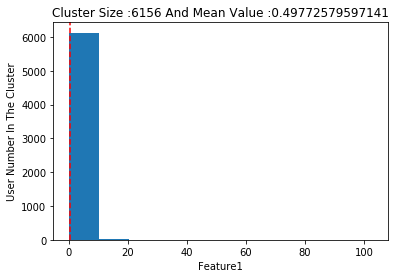

Level :3
Feature1
Cluster Size :6156
______________________________________
Silhouette Score :0.8974835501232943
Cluster Count :2


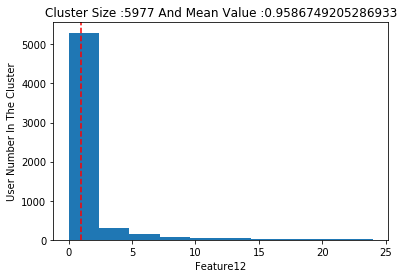

Level :4
Feature12
Cluster Size :5977
______________________________________
Silhouette Score :0.9379359983270023
Cluster Count :2


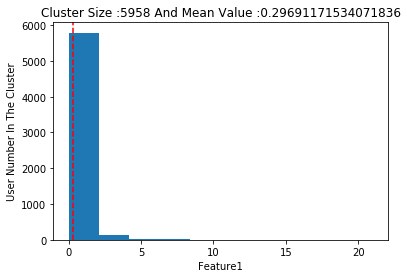

Level :5
Feature1
Cluster Size :5958
______________________________________
Silhouette Score :0.7857249231205435
Cluster Count :2


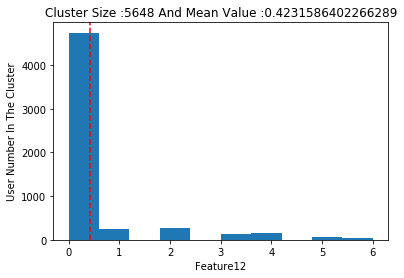

Level :6
Feature12
Cluster Size :5648
______________________________________
Silhouette Score :0.7119978483768497
Cluster Count :2


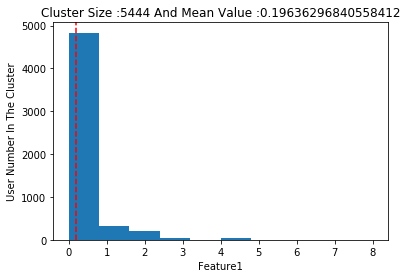

Level :7
Feature1
Cluster Size :5444
______________________________________


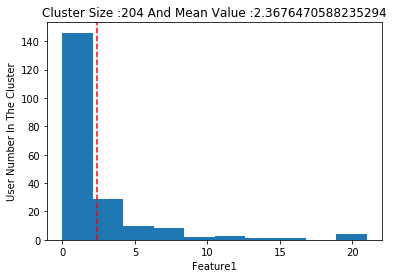

Level :7
Feature1
Cluster Size :204
______________________________________


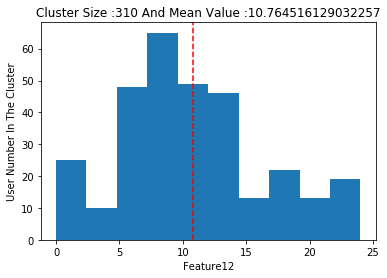

Level :6
Feature12
Cluster Size :310
______________________________________


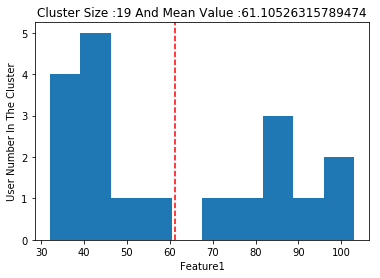

Level :5
Feature1
Cluster Size :19
______________________________________
Silhouette Score :0.6849134173110368
Cluster Count :2


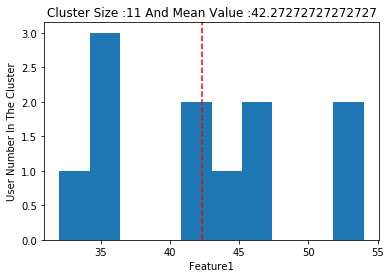

Level :6
Feature1
Cluster Size :11
______________________________________


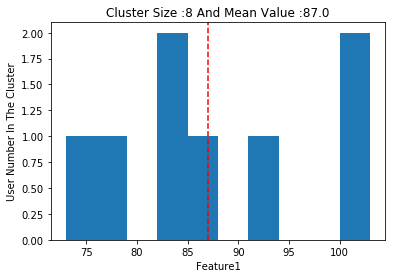

Level :6
Feature1
Cluster Size :8
______________________________________


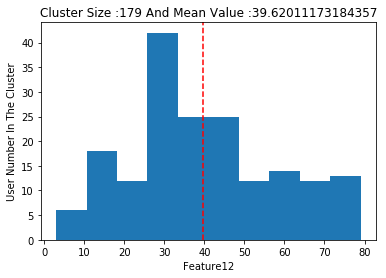

Level :4
Feature12
Cluster Size :179
______________________________________


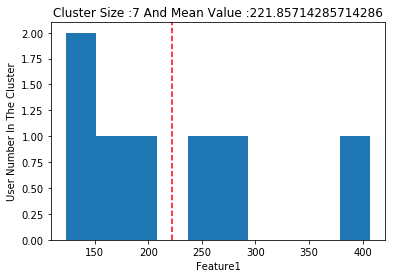

Level :3
Feature1
Cluster Size :7
______________________________________


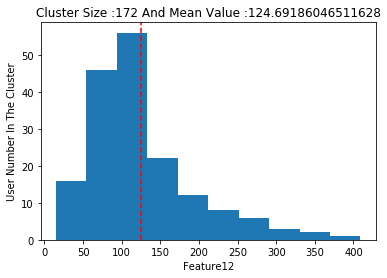

Level :2
Feature12
Cluster Size :172
______________________________________


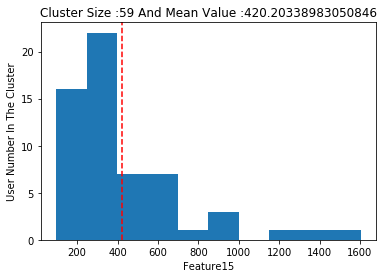

Level :1
Feature15
Cluster Size :59
______________________________________


In [3]:
totalInstances=len(transformedValues)

#recursive hierarchical clustering function
def hierarchicalClustering(parentCluster,level,positions,parent,clusterList):
    silhouetteScore=-1
    #tree node count dictionary at each level for labelling
    global globalCount
    
    if(len(parentCluster) < 2):
        return  
    
    clusterCount=2
    #clustering
    clusterer = KMeans(n_clusters=clusterCount,random_state=0)
    kmeans = clusterer.fit(parentCluster)
    clusterLabels = clusterer.fit_predict(parentCluster)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    if(1 < len(set(clusterLabels)) < len(parentCluster)):
        silhouetteScore = silhouette_score(parentCluster, clusterLabels)
    
    #silhoutte score threshold check
    if(silhouetteScore < silhouetteThreshold):
        return
    print("Silhouette Score :"+ str(silhouetteScore))
    print("Cluster Count :"+str(clusterCount))
    
    
    indeX=chi2(parentCluster, clusterLabels)[0].tolist()
    #finding max chi score and its feature index
    chi_max=0
    iterator=0
    index_=-1
    featureSignificance={}
    while (iterator < len(indeX)):
        featureSignificance[attributes[iterator]]=indeX[iterator]
        if(indeX[iterator] > chi_max):
            chi_max=indeX[iterator]
            index_=iterator
        iterator=iterator+1
    featureSignificanceSorted=sorted(featureSignificance.items(), key=lambda x: x[1], reverse=True)
    try :
        globalCount[level]
    except:
        globalCount[level]=0

    final_=[]
    childCluster=[]
    {iterator: final_.append(numpy.where(kmeans.labels_ == iterator)[0]) for iterator in range(kmeans.n_clusters)}
    clusterIterator=0
    
    #for each cluster formed
    while clusterIterator < kmeans.n_clusters:
        iterator=0
        childCluster=[]
        new_positions=[]
        ids=[]
        while iterator < len(final_[clusterIterator]): 
            childCluster.append(parentCluster[final_[clusterIterator][iterator]])
            new_positions.append(positions[final_[clusterIterator][iterator]])
            ids.append(user[positions[final_[clusterIterator][iterator]]])
            iterator=iterator+1
            
        #cluster data interpretation
        clusterSummary={}
        clusterName='L'+str(level)+'G'+str(globalCount[level])
        dataIds=pandas.DataFrame(ids, columns = ["IDS"])
        dataStats = pandas.DataFrame(childCluster, columns = attributes)
        stats=dataStats[attributes].head(n=len(childCluster)).describe()
        clusterSummary['ClusterId']=clusterName
        clusterSummary['Size']=len(childCluster)
        clusterSummary['Primary feature cluster created by']=attributes[index_]
        clusterSummary['Features chi score']=featureSignificanceSorted
        clusterSummary['Stats on cluster by each feature']=stats.to_dict()
        clusterSummary['Ids']=ids
        clusterSummaryJson=json.dumps(clusterSummary,ensure_ascii = 'False',indent=4)
        fh = open(statsPath+clusterName+'clusterDescription'+".json","w")
        fh.write("[" + clusterSummaryJson + "]")
        fh.close()
        dataStats[attributes[index_]].plot(kind='hist')
        plt.title("Cluster Size :"+str(len(childCluster))+" And Mean Value :"+str(dataStats[attributes[index_]].mean()))
        plt.ylabel('User Number In The Cluster')
        plt.xlabel(attributes[index_])
        plt.axvline( dataStats[attributes[index_]].mean(),linestyle='dashed',color='r')
        plt.savefig(statsPath+clusterName+ '.png')
        plt.show()
        print("Level :"+ str(level))
        print(attributes[index_])
        print("Cluster Size :"+str(len(childCluster)))
        clusterIterator=clusterIterator+1
        processingList={}
        processingList["name"]=clusterName
        processingList["desc"]=clusterName+",Cluster Size :"+str(len(childCluster))+',Split by :'+str(attributes[index_])+",Mean : "+str(round(dataStats[attributes[index_]].mean(),4))
        processingList["parent"]=parent
        processingList['size']=len(childCluster)
        
        if(float(len(childCluster)/len(parentCluster)) < 0.1):
            processingList['line_color']='red'
            processingList['alert_color']='red'
                
        else: 
            processingList['line_color']='#000'
            processingList['alert_color']='#000'
                
        processingList["children"]=[]
        
        print("______________________________________")
        globalCount[level]=globalCount[level]+1
        hierarchicalClustering(childCluster,level+1,new_positions,clusterName,processingList["children"])
        clusterList.append(processingList)


iterator=0
positions=list(range(0,len(transformedValues)))
globalCount={}
clusterList={}
what={}
clusterList["name"]='L0G0'
clusterList["parent"]="null"
clusterList["desc"]="Cluster Size :"+str(len(transformedValues))
clusterList['size']=len(transformedValues)
clusterList['line_color']='#000'
clusterList['alert_color']='#000'
clusterList["children"]=[]
hierarchicalClustering(transformedValues,1,positions,'L0G0',clusterList["children"])


In [4]:
#Store JSON
maximumKey=0
maximumValue=0
for key,value in globalCount.items():
    if(key > maximumKey):
        maximumKey=key
    if(value > maximumValue):
        maximumValue=value
clusterList["height"]=maximumKey
clusterList["width"]=maximumValue
clusterListJson=json.dumps(clusterList,ensure_ascii = 'False',indent=4)
fh = open(visualisationDirectory+dataFile+".json","w")
fh.write("[" + clusterListJson + "]")
fh.close()

In [5]:
#append tree to tree list
treeList=[]
write=True
if(os.path.exists(modelNameFilePath)):
    fh = open(modelNameFilePath,"r")
    treeList=ast.literal_eval(fh.read())
    if (str(dataFile)) not in treeList:
        treeList.append(dataFile)
    else:
        write=False
else:
    treeList.append(dataFile)
    
if(write):    
    fh = open(modelNameFilePath,"w")
    fh.write(json.dumps(treeList,ensure_ascii = 'False'))
    fh.close()
